In [2]:
from scipy import misc
from scipy import ndimage

import numpy as np
import matplotlib.pyplot as plt

# Kernels is a simple class which contains the filter-kernels.
# Didn't want to dumb this file
import kernels

(512, 512)


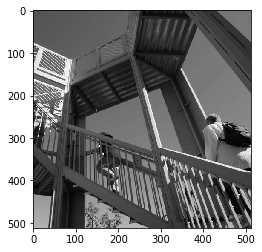

In [38]:
img = misc.ascent() # a sample image of two guys walking upstairs
#img = misc.face(gray=True) # A standard raccoon
#img = ndimage.imread("Kadse.png") # Felix, performs very very bad
#img=ndimage.imread("Pikachu.png",mode='L') # Cartoon Image, works fine as it has really clear edges
#img = ndimage.imread("MontreMolle.jpg",mode='L')
print(img.shape)
plt.gray()
plt.imshow(img)
plt.show()

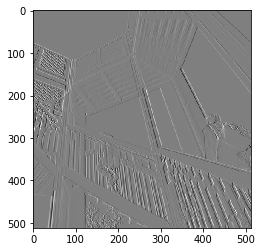

In [39]:
simpleFilter = [-1,0,1]
xEdges = ndimage.filters.convolve1d(img,simpleFilter)
plt.imshow(xEdges)
plt.show()

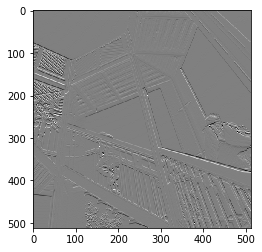

In [40]:
yEdges = ndimage.filters.convolve1d(img,simpleFilter,axis=0);
plt.imshow(yEdges)
plt.show()

In [41]:
def magnitude(xEdges,yEdges):
    return np.sqrt(np.power(yEdges,2) + np.power(xEdges,2))

def direction(xEdges,yEdges):
    return np.asarray([np.max(np.arctan([a,b])) for a,b in np.nditer([xEdges,yEdges])]).reshape(xEdges.shape)

In [42]:
def simpleEdgeDetection(img):
    simpleFilter = [-1,0,1]
    xEdges = ndimage.filters.convolve1d(img,simpleFilter) * 0.5
    yEdges = ndimage.filters.convolve1d(img,simpleFilter,axis=0) * 0.5
    return np.asarray(magnitude(xEdges,yEdges),dtype="uint8")

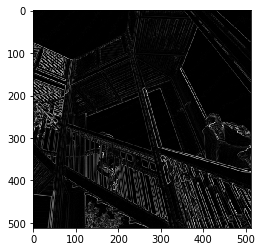

In [43]:
plt.imshow(simpleEdgeDetection(img))

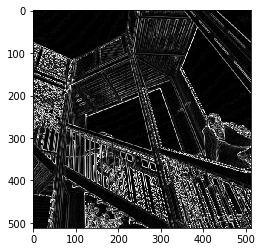

In [44]:
prewittX = ndimage.filters.convolve(img,kernels.prewittX)
prewittY = ndimage.filters.convolve(img,kernels.prewittY)
prewitt = magnitude(prewittX,prewittY)

prewitt = np.asarray(prewitt,dtype='uint8') # Floats cannot be plotted as gray images :(
plt.imshow(prewitt)
plt.show()

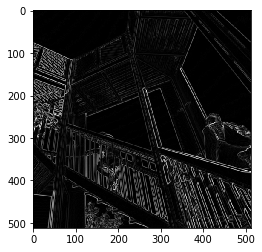

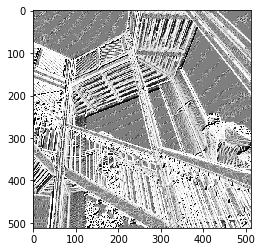

In [45]:
sobelX = ndimage.filters.convolve(img,kernels.sobelX)*0.125
sobelY = ndimage.filters.convolve(img,kernels.sobelY)*0.125
sobel = magnitude(sobelX,sobelY)
sobeldirs = direction(sobelX,sobelY)
plt.imshow(sobel)
plt.show()
plt.imshow(sobeldirs)
plt.show()

In [46]:
def compass(img, filterarray, coeff):
    imgArr = np.asarray([ndimage.filters.convolve(img,filter)*coeff for filter in filterarray])
    helper = imgArr.transpose(1,2,0)
    magnitude = helper.max(axis=2)
    compass = helper.argmax(axis=2)
    return magnitude,compass

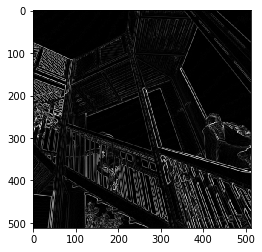

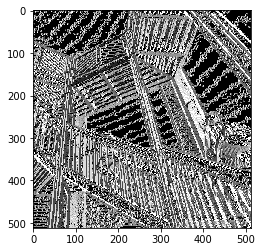

In [47]:
extS = np.asarray(kernels.extendedSobel)
c = compass(img,extS,0.125)
plt.imshow(c[0])
plt.show()
plt.imshow(c[1])
plt.show()

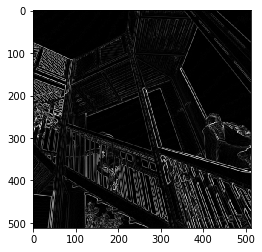

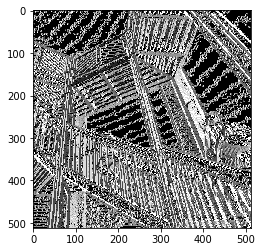

In [48]:
kirsch = np.asarray(kernels.kirsch)
c = compass(img,extS,0.125)
plt.imshow(c[0])
plt.show()
plt.imshow(c[1])
plt.show()

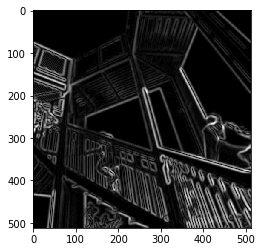

In [49]:
def preprocessCannyEdge(img,sigma=2):
    gaussed = ndimage.filters.gaussian_filter(img,sigma)
    return simpleEdgeDetection(gaussed)

plt.imshow(preprocessCannyEdge(img))
plt.show()

In [50]:
def laplacianMask(img):
    filters = np.asarray(kernels.maxCompass)
    imgArr = np.asarray([ndimage.filters.convolve(img,f) for f in filters])
    helper = imgArr.transpose(1,2,0)
    helper= helper.reshape(helper.shape[0]*helper.shape[1],8)
    mask = np.asarray([(0 in tupel) for tupel in helper]).reshape(img.shape)
    return mask

def edgeLocalization(edgeImg,mask):
    return np.asarray([v if m else 0 for v,m in np.nditer([edgeImg,mask])]).reshape(edgeImg.shape)

In [51]:
mask = laplacianMask(img)
edgeImg = preprocessCannyEdge(img)
localizedEdges = edgeLocalization(edgeImg,mask)

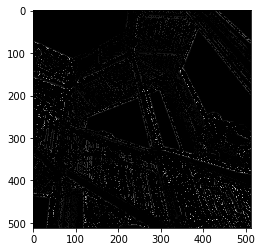

In [52]:
plt.imshow(localizedEdges)

In [53]:
def hysteresisThreshhold(edgeImg, t0, t1):
    evertrues = np.asarray([p>=t0 for p in edgeImg]).reshape(edgeImg.shape)
    hysteresisMask = evertrues.copy()
    lastMask = np.asarray(np.zeros(edgeImg.shape),dtype=bool)
    while any(np.bitwise_xor(lastMask.ravel(),hysteresisMask.ravel())): 
        lastMask = hysteresisMask
        possibleNeighboors = ndimage.binary_dilation(hysteresisMask)
        hysteresisMask = np.asarray([p>=t1 and n for (p,n) in np.nditer([edgeImg,possibleNeighboors])]).reshape(edgeImg.shape)
    masked = np.asarray([p if m else 0 for p,m in np.nditer([edgeImg,hysteresisMask])]).reshape(edgeImg.shape)
    return masked

In [54]:
def cannyEdge(img,t0,t1,sigma=2):
    mask = laplacianMask(img)
    edgeImg = preprocessCannyEdge(img,sigma)
    localizedEdges = edgeLocalization(edgeImg,mask)
    final = hysteresisThreshhold(localizedEdges,t0,t1)
    return final

Wall time: 6.54 s


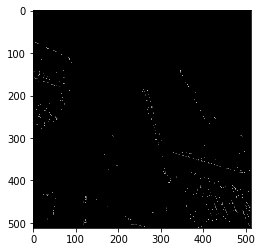

In [61]:
%%time
plt.imshow(cannyEdge(img,15,5))